In [1]:
# This file predicts Arrest v No Arrest using a RandomTreeClassifier.
# Uses GridSearchCV to get best RandomTreeClassifier params.
# Also lists features in order of importance, as determined by the RandomTreeClassifier.

In [2]:
import pandas as pd
import numpy as np
data_types = {
    'ID':  np.int64,
    'Case Number':  object,
    'Date': object,
    'Block': object,
    'IUCR': object,
    'Primary Type': object,
    'Description':  object,
    'Location Description': object,
    'Arrest':  bool,
    'Domestic': bool,
    'Beat': np.int64,
    'District': np.float64,
    'Ward': np.float64,
    'Community Area': np.float64,
    'FBI Code': object,
    'X Coordinate': np.float64,
    'Y Coordinate': np.float64,
    'Year': np.int64,
    'Updated On': object,
    'Latitude': np.float64,
    'Longitude': np.float64,
    'Location': object
}
df = pd.read_csv('crimes.csv', dtype=data_types)

In [3]:
poverty = pd.read_csv('poverty.csv')
poverty = poverty.drop('COMMUNITY AREA NAME', 1)

In [4]:
# Remove unwanted columns from the data
# Add 'Date' back in when RJ fixes the datetime converter
useful_columns = ['IUCR', 'Location Description', 'Arrest', 'Domestic', 'Community Area', 'Year']
data_full = df[useful_columns]

In [5]:
# Merge with the poverty dataframe
data_full = data_full.rename(columns={'Community Area': 'Community Area Number'})
data_full = pd.merge(data_full, poverty, how='right', on='Community Area Number')

In [6]:
# Also resample to a smaller size for now
num_records = 300000
data = data_full.sample(num_records, replace=True)
data = data.dropna()
data.head()

,IUCR,Location Description,Arrest,Domestic,Community Area Number,Year,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
1667024,4387,RESIDENCE,False,False,73.0,2005,1.1,16.9,20.8,13.7,42.6,19713,48.0
5114905,0810,VEHICLE NON-COMMERCIAL,False,False,14.0,2015,11.3,19.2,10.0,32.9,32.0,21323,53.0
2594832,2820,APARTMENT,False,False,29.0,2011,7.4,43.1,21.2,27.6,42.7,12034,87.0
5165183,1345,"SCHOOL, PUBLIC, BUILDING",False,False,11.0,2005,2.7,8.6,12.4,13.4,35.5,27751,25.0
1910270,143A,OTHER,True,False,49.0,2003,2.5,19.8,20.3,16.9,41.2,17949,52.0


In [7]:
d_subset = data
dummy_vars = ['Year', 'IUCR', 'Location Description', 'Community Area Number']
data = pd.get_dummies(d_subset, columns=dummy_vars, drop_first=True, sparse=True)
data.head()

,Arrest,Domestic,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,Year_2002,...,Community Area Number_68.0,Community Area Number_69.0,Community Area Number_70.0,Community Area Number_71.0,Community Area Number_72.0,Community Area Number_73.0,Community Area Number_74.0,Community Area Number_75.0,Community Area Number_76.0,Community Area Number_77.0
1667024,False,False,1.1,16.9,20.8,13.7,42.6,19713,48.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
5114905,False,False,11.3,19.2,10.0,32.9,32.0,21323,53.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2594832,False,False,7.4,43.1,21.2,27.6,42.7,12034,87.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
5165183,False,False,2.7,8.6,12.4,13.4,35.5,27751,25.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1910270,True,False,2.5,19.8,20.3,16.9,41.2,17949,52.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [8]:
# Dependent and independent variables
from sklearn.cross_validation import train_test_split
dep_var = ['Arrest']
indep_var = filter(lambda x: x not in dep_var, data.columns.values)
X = data[indep_var]
y = data[dep_var]
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.head()

,Domestic,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,Year_2002,Year_2003,...,Community Area Number_68.0,Community Area Number_69.0,Community Area Number_70.0,Community Area Number_71.0,Community Area Number_72.0,Community Area Number_73.0,Community Area Number_74.0,Community Area Number_75.0,Community Area Number_76.0,Community Area Number_77.0
306860,False,1.9,12.9,7.0,2.5,22.6,88669,1.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4741704,False,9.4,41.7,25.8,24.5,43.6,10934,92.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1669926,False,1.1,16.9,20.8,13.7,42.6,19713,48.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
4581459,False,1.3,13.8,4.9,7.4,21.8,59077,7.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1173918,False,3.8,20.6,10.7,9.6,22.2,44689,15.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [9]:
# Helper functions
%matplotlib inline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from __future__ import division

def cm_loss(estimator, X, y):
    predictions = estimator.predict(X)
    cm = confusion_matrix(y, predictions)
    totals = np.sum(cm, 1)
    no_acc = cm[0, 0] / totals[0]
    yes_acc = cm[1, 1] / totals[1]
    return (no_acc + yes_acc)/2

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Arrest', 'No Arrest'], rotation=45)
    plt.yticks(tick_marks, ['Arrest', 'No Arrest'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def accuracies(cm):
    totals = np.sum(cm, 1)
    no_acc = cm[0, 0] / totals[0]
    yes_acc = cm[1, 1] / totals[1]
    print("Arrest Acc: {0}".format(no_acc))
    print("No Arrest Acc: {0}".format(yes_acc))
    print("Avg Acc: {0}".format((no_acc + yes_acc)/2))

In [10]:
X_train.shape

(180496, 556)

/Users/nishanthshanmugham/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.1s finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=True,
            warm_start=False)
[[58575  5125]
 [ 8084 17118]]
Arrest Acc: 0.919544740973
No Arrest Acc: 0.679231806999
Avg Acc: 0.799388273986


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


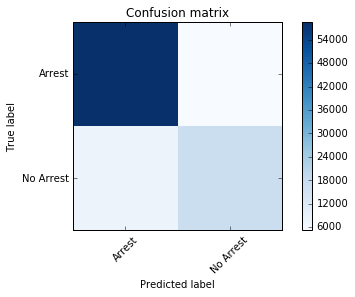

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
model = RandomForestClassifier(verbose=True, class_weight='balanced')
print model

model.fit(X_train, y_train)
predictions = model.predict(X_test)

cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm)
accuracies(cm)

In [12]:
# Order of importance
fi = zip(X_train.columns, model.feature_importances_)
fi_sort = sorted(fi, key=lambda (x,y): y, reverse=True)
fi_sort

[('IUCR_1811', 0.063216959514320131),
 ('IUCR_0820', 0.03228946094840842),
 ('IUCR_0810', 0.028103384804394449),
 ('IUCR_1320', 0.028041466075351629),
 ('IUCR_2027', 0.025533481751790366),
 ('Location Description_RESIDENCE', 0.019729941108390492),
 ('IUCR_0890', 0.019558241406331604),
 ('IUCR_1330', 0.018948683552979562),
 ('IUCR_0910', 0.017560555151308124),
 ('IUCR_2024', 0.017424292063614333),
 ('Domestic', 0.016922343546234463),
 ('IUCR_0460', 0.016716061739423131),
 ('Location Description_SIDEWALK', 0.015719943951309663),
 ('IUCR_0610', 0.015610416906697202),
 ('IUCR_1310', 0.015145054403226091),
 ('PER CAPITA INCOME ', 0.014937651423148471),
 ('PERCENT HOUSEHOLDS BELOW POVERTY', 0.012925624797957381),
 ('PERCENT OF HOUSING CROWDED', 0.012544452781336573),
 ('Year_2003', 0.012496716207276885),
 ('Year_2005', 0.012405380799783627),
 ('Year_2004', 0.011956119226901778),
 ('Year_2007', 0.011918702423846047),
 ('Year_2006', 0.011884150574434893),
 ('PERCENT AGED 25+ WITHOUT HIGH SCHOO

In [21]:
import json
from urllib import urlopen
url = urlopen("https://data.cityofchicago.org/api/views/c7ck-438e/rows.json?accessType=DOWNLOAD")
json.loads(url.read())

{u'data': [[1,
   u'2E65B109-A0AC-478C-9976-FE048215A4DA',
   1,
   1410819111,
   u'700397',
   1410819111,
   u'700397',
   u'{\n}',
   u'110',
   u'HOMICIDE',
   u'FIRST DEGREE MURDER',
   u'I'],
  [2,
   u'3F8F0E12-3A3D-4A8E-BE9F-9BDA67FF02E2',
   2,
   1410819111,
   u'700397',
   1410819111,
   u'700397',
   u'{\n}',
   u'130',
   u'HOMICIDE',
   u'SECOND DEGREE MURDER',
   u'I'],
  [3,
   u'03D25032-CD09-4C1E-94DF-744F3BE0E1E4',
   3,
   1410819111,
   u'700397',
   1410819111,
   u'700397',
   u'{\n}',
   u'141',
   u'HOMICIDE',
   u'INVOLUNTARY MANSLAUGHTER',
   u'N'],
  [4,
   u'E35A07B2-8838-406B-9F04-F5C5279DA2E2',
   4,
   1410819111,
   u'700397',
   1410819111,
   u'700397',
   u'{\n}',
   u'142',
   u'HOMICIDE',
   u'RECKLESS HOMICIDE',
   u'N'],
  [5,
   u'7D5C55CD-D735-4676-8DBB-9060A308738B',
   5,
   1410819111,
   u'700397',
   1410819111,
   u'700397',
   u'{\n}',
   u'261',
   u'CRIM SEXUAL ASSAULT',
   u'AGGRAVATED: HANDGUN',
   u'I'],
  [6,
   u'54A2DD32-E169-4

notes

```
"1811", "NARCOTICS", "POSS: CANNABIS 30GMS OR LESS"
"820", "THEFT", "$500 AND UNDER"
"810", "THEFT", "OVER $500"
"1320", "CRIMINAL DAMAGE", "TO VEHICLE"
"2027", "NARCOTICS", "POSS: CRACK"
```